<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/CorneAI_GradCAM%E8%AB%96%E6%96%87_Figure_250722.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**YOLOv5_GradCAM_CutPaste_Figure**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


#**Figure S1**

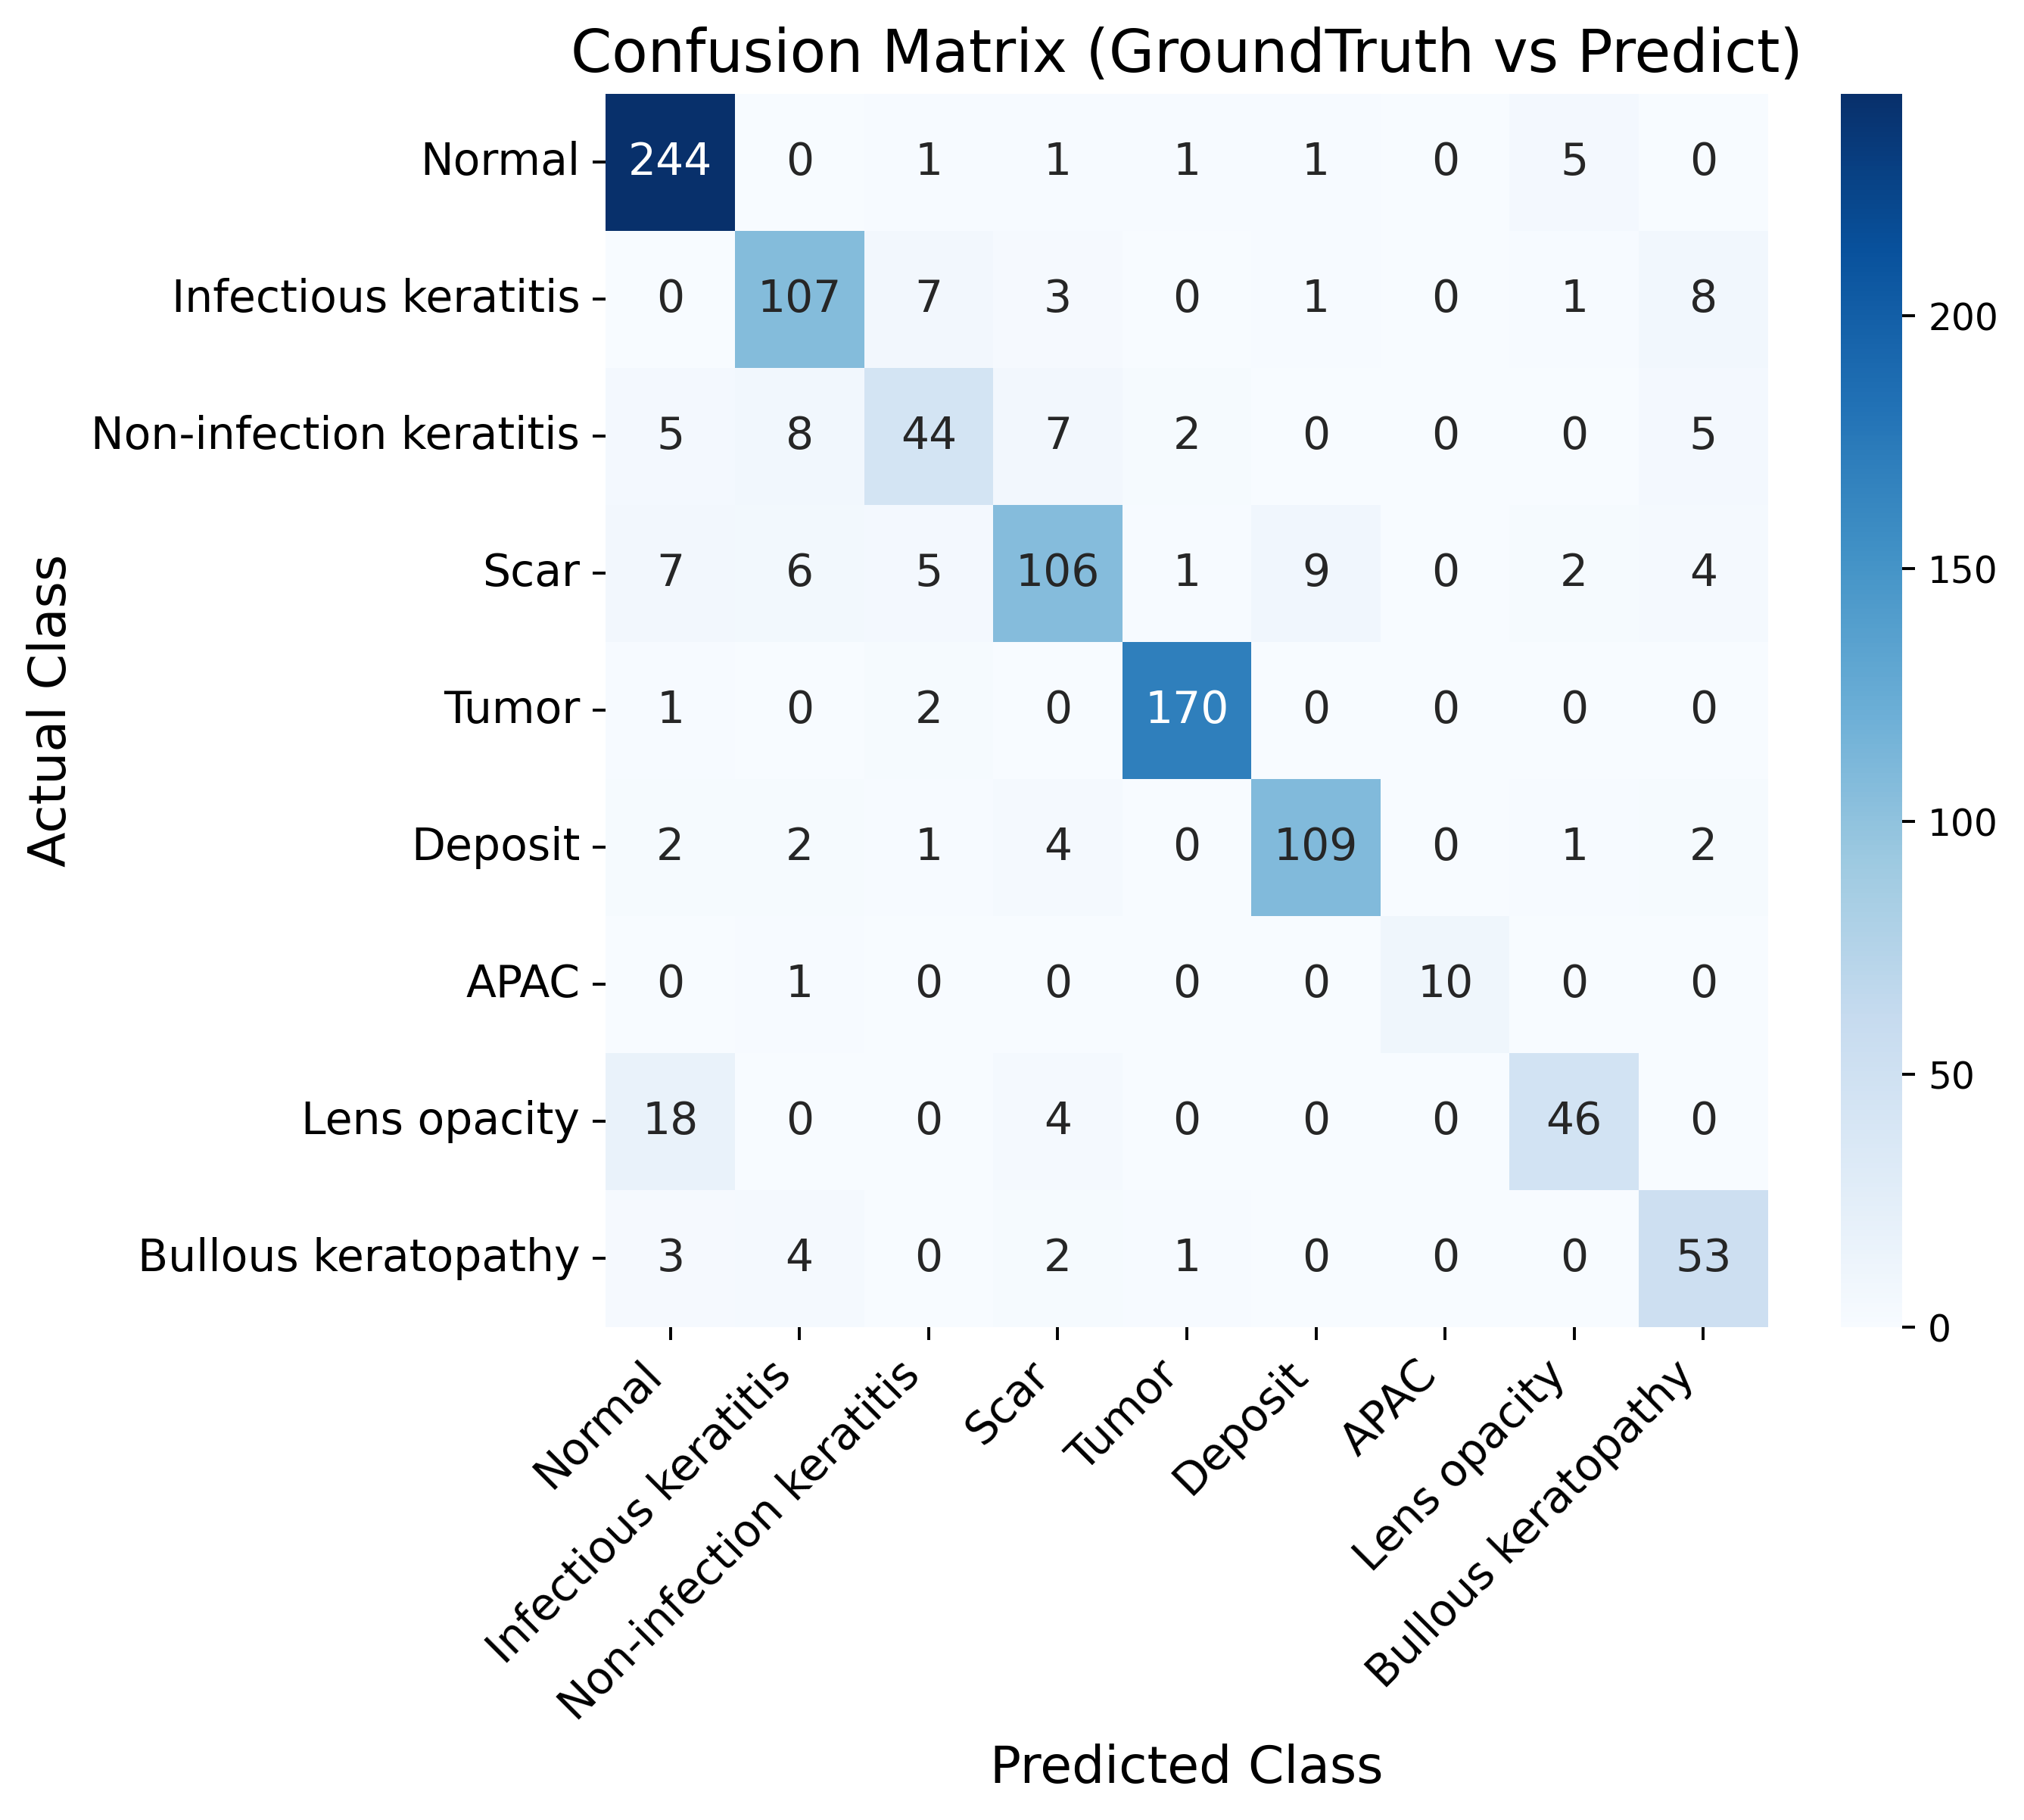

In [ ]:
# ────────────────────────────────────────────────────────────────
# Confusion Matrix  —  GroundTruth vs Predict  (Grad‑CAM dataset)
# ────────────────────────────────────────────────────────────────
#
# ❶  CSV  ファイルを読み込む
# ❷  GroundTruth / Predict をラベル文字列に変換
# ❸  pandas.crosstab で混同行列を作成
# ❹  seaborn.heatmap で描画・保存（350 dpi）
#     フォントサイズは下の設定を変更
# ────────────────────────────────────────────────────────────────

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === フォントサイズ設定 ===============================
TITLE_FONT   = 16   # タイトル
LABEL_FONT   = 14   # 軸ラベル
TICK_FONT    = 12   # 目盛りラベル
ANNOT_FONT   = 12  # ヒートマップ数値
# =====================================================

# --- ❶  CSVパス（Google Drive 等に合わせて変更してください） ---
file_path = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv'
df = pd.read_csv(file_path, encoding='utf-8')

# --- ❷  ラベルマッピング ---------------------------------------
label_map = {
    'normal'        : 'Normal',
    'infection'     : 'Infectious keratitis',
    'non-infection' : 'Non-infection keratitis',
    'scar'          : 'Scar',
    'tumor'         : 'Tumor',
    'deposit'       : 'Deposit',
    'APAC'          : 'APAC',
    'lens opacity'  : 'Lens opacity',
    'bullous'       : 'Bullous keratopathy'
}
df['gt_label']   = df['GroundTruth'].map(label_map)
df['pred_label'] = df['Predict'].map(label_map)

class_names = [
    'Normal',
    'Infectious keratitis',
    'Non-infection keratitis',
    'Scar',
    'Tumor',
    'Deposit',
    'APAC',
    'Lens opacity',
    'Bullous keratopathy'
]

# --- ❸  混同行列 ----------------------------------------------
conf_matrix = (
    pd.crosstab(df['gt_label'], df['pred_label'])
      .reindex(index=class_names, columns=class_names, fill_value=0)
)

# --- ❹  プロット ----------------------------------------------
plt.figure(figsize=(8, 7), dpi=350)
sns.heatmap(conf_matrix,
            annot=True, fmt='d', cmap='Blues',
            annot_kws={'size': ANNOT_FONT},
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix (GroundTruth vs Predict)', fontsize=TITLE_FONT)
plt.xlabel('Predicted Class', fontsize=LABEL_FONT)
plt.ylabel('Actual Class', fontsize=LABEL_FONT)
plt.xticks(rotation=45, ha='right', fontsize=TICK_FONT)
plt.yticks(rotation=0, fontsize=TICK_FONT)
plt.tight_layout()
plt.savefig('confusion_matrix_gradcam_350dpi.png', dpi=350, bbox_inches='tight')
plt.show()


#**Figure S2**

In [ ]:
# ============================================
# Grad-CAM++ AOI 0.5 可視化フルコード
# (x軸ラベルを layer17_cv3_conv 形式, layermodel_除去)
# Figure S2を作成
# ============================================

from google.colab import drive
drive.mount('/content/drive')

# === パス設定 ===
CSV_PATH_DRIVE = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_gradcam++.csv"
LOCAL_CSV_PATH = "/content/Ueno_Mix1039_gradcam++.csv"
!cp "$CSV_PATH_DRIVE" "$LOCAL_CSV_PATH"

# === ライブラリ ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path, PurePath
import re

# === 設定 ===
CSV_PATH = Path(LOCAL_CSV_PATH)
OUT_DIR  = Path("/content")
OUT_DIR.mkdir(parents=True, exist_ok=True)

RAW_LAYER_COLS = [
    'AOI_0.5_layermodel_17_cv3_conv',
    'AOI_0.5_layermodel_20_cv3_conv',
    'AOI_0.5_layermodel_23_cv3_conv',
    'AOI_0.5_layer24_m_0',
    'AOI_0.5_layer24_m_1',
    'AOI_0.5_layer24_m_2'
]

POSSIBLE_CLASSES = [
    'normal', 'infection', 'non-infection', 'scar', 'tumor',
    'deposit', 'APAC', 'lens opacity', 'bullous'
]

# === 名称変換 ===
def to_axis_label(col: str) -> str:
    """
    入力: AOI_0.5_layermodel_17_cv3_conv → 出力: layer17_cv3_conv
    入力: AOI_0.5_layer24_m_0          → 出力: layer24_m_0
    """
    # AOI_0.5_ を除去
    name = re.sub(r'^AOI_0\.5_', '', col)
    # layermodel_ を除去
    name = name.replace('layermodel_', 'layer')
    return name

LAYER_AXIS_LABEL = {c: to_axis_label(c) for c in RAW_LAYER_COLS}

# === スタイル ===
mpl.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.linewidth': 1.0,
})
BOX_FACE, EDGE_COLOR, MEDIAN_COLOR = "#C8C8C8", "black", "black"
BOX_WIDTH, DPI = 0.8, 350

# === データ読み込み ===
if not CSV_PATH.exists():
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

missing = [c for c in RAW_LAYER_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")
if 'GroundTruth' not in df.columns:
    raise ValueError("Column 'GroundTruth' not found in CSV.")

df_layers = df.dropna(subset=RAW_LAYER_COLS, how='all').copy()
df_layers = df_layers[~df_layers['GroundTruth'].isna()].copy()

class_order = [c for c in POSSIBLE_CLASSES if c in df_layers['GroundTruth'].unique()]
print("Class order:", class_order)

# === プロット関数 ===
def save_and_show_boxplot(data, labels, title, ylabel, filename,
                          rotate=True, ylim=None, showfliers=True):
    plt.figure(figsize=(8,5))
    bp = plt.boxplot(
        data, labels=labels, patch_artist=True, showfliers=showfliers,
        widths=BOX_WIDTH,
        boxprops=dict(linewidth=1.0, color=EDGE_COLOR),
        whiskerprops=dict(linewidth=1.0, color=EDGE_COLOR),
        capprops=dict(linewidth=1.0, color=EDGE_COLOR),
        medianprops=dict(linewidth=1.4, color=MEDIAN_COLOR),
        flierprops=dict(marker='o', markersize=3, markerfacecolor=EDGE_COLOR,
                        markeredgecolor=EDGE_COLOR, alpha=0.8)
    )
    for b in bp['boxes']:
        b.set_facecolor(BOX_FACE)
    plt.title(title, pad=6)
    plt.ylabel(ylabel)
    if rotate:
        plt.xticks(rotation=30, ha='right')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    out_path = OUT_DIR / filename
    plt.savefig(out_path, dpi=DPI, bbox_inches='tight')
    plt.show()
    return out_path

# === 1) 全レイヤ比較 ===
# === 1) 全レイヤ比較 ===
data_layers   = [df_layers[col].dropna().values for col in RAW_LAYER_COLS]
labels_layers = ["Layer 17", "Layer 20", "Layer 23", "Layer 24-0", "Layer 24-1", "Layer 24-2"]  # ← ここを更新
overall_png = save_and_show_boxplot(
    data_layers, labels_layers,
    "Comparison of AOI_0.5 Values Across Layers",
    "AOI_0.5",
    "AOI_0.5_layers_comparison_350dpi.png"
)
print("Saved:", overall_png)

# === 2) 各レイヤ クラス別 ===
per_class_pngs = []
for raw_col in RAW_LAYER_COLS:
    axis_label = LAYER_AXIS_LABEL[raw_col]  # タイトルと y軸ラベルに使用
    df_c = df_layers[['GroundTruth', raw_col]].dropna()
    class_data, class_labels = [], []
    for cls in class_order:
        vals = df_c[df_c['GroundTruth'] == cls][raw_col].values
        if len(vals) > 0:
            class_data.append(vals)
            class_labels.append(cls)
    if not class_data:
        continue
    out = save_and_show_boxplot(
        class_data, class_labels,
        axis_label,        # ← タイトルを簡略名のみ
        "AOI_0.5",         # y軸は共通で AOI_0.5
        f"{axis_label}_per_class_350dpi.png"
    )
    per_class_pngs.append(out)
    print("Saved:", out)

# === 3) レイヤ全体統計 ===
summary_rows = []
for col in RAW_LAYER_COLS:
    vals = df_layers[col].dropna()
    if len(vals) == 0:
        continue
    q1,q2,q3 = np.percentile(vals, [25,50,75])
    summary_rows.append({
        "layer_raw": col,
        "layer_label": LAYER_AXIS_LABEL[col],
        "n": len(vals),
        "median": q2,
        "q1": q1,
        "q3": q3,
        "IQR": q3 - q1,
        "mean": vals.mean(),
        "std": vals.std()
    })
summary_df = pd.DataFrame(summary_rows).sort_values("layer_label")
summary_csv = OUT_DIR / "AOI_0.5_layers_summary_stats.csv"
summary_df.to_csv(summary_csv, index=False)
print("Saved:", summary_csv)
display(summary_df)

# === 4) 各レイヤ × クラス統計 ===
class_stats_paths = []
for col in RAW_LAYER_COLS:
    axis_label = LAYER_AXIS_LABEL[col]
    rows = []
    for cls in class_order:
        cls_vals = df_layers.loc[df_layers['GroundTruth']==cls, col].dropna()
        if len(cls_vals)==0:
            continue
        q1,q2,q3 = np.percentile(cls_vals,[25,50,75])
        rows.append({
            "layer_label": axis_label,
            "class": cls,
            "n": len(cls_vals),
            "median": q2,
            "q1": q1,
            "q3": q3,
            "IQR": q3-q1,
            "mean": cls_vals.mean(),
            "std": cls_vals.std()
        })
    if rows:
        layer_stats_df = pd.DataFrame(rows)
        out_csv = OUT_DIR / f"{axis_label}_class_stats.csv"
        layer_stats_df.to_csv(out_csv, index=False)
        class_stats_paths.append(out_csv)
        print("Saved:", out_csv)
        display(layer_stats_df)

# === 5) （任意）ダウンロード ===
from google.colab import files
files.download(str(overall_png))
for p in per_class_pngs: files.download(str(p))
# files.download(str(summary_csv))
# for p in class_stats_paths: files.download(str(p))

print("All done.")

#**Figre 5**

In [ ]:
# Google Colab FULL SCRIPT — Ueno_Mix1039 Cut‑and‑Paste Background Analysis
# =============================================================================
# ① Google Drive をマウント
from google.colab import drive
drive.mount('/gdrive')

# ② ライブラリ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2_contingency, norm
from statsmodels.stats.multitest import multipletests

# ------------------------------------------------------------
# ③ パス & データ読込
# ------------------------------------------------------------
FILE_PATH = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_cutmix.csv'
df = pd.read_csv(FILE_PATH)

# ------------------------------------------------------------
# ④ ラベル置換（必要に応じて編集）
# ------------------------------------------------------------
label_map = {
    "infection":         "Infectious keratitis",
    "normal":            "Normal",
    "non-infection":     "Non-infectious keratitis",
    "scar":              "Scar",
    "tumor":             "Tumor",
    "deposit":           "Deposit",
    "apac":              "APAC",
    "lens opacity":      "Lens opacity",
    "bullous":           "Bullous keratopathy"
}
for col in ['cornea_class', 'background_class', 'cutmix_pred']:
    df[col] = df[col].replace(label_map)

classes = [
    "Normal", "Infectious keratitis", "Non-infectious keratitis",
    "Scar", "Tumor", "Deposit", "APAC", "Lens opacity", "Bullous keratopathy"
]

# ユーティリティ: 空白・NaN を除外するマスク
def valid_mask(series):
    return series.notna() & (series.astype(str).str.strip() != '')

# Wilson 95 % CI
def wilson_ci(successes, n, conf=0.95):
    if n == 0: return (np.nan, np.nan)
    p_hat, z = successes / n, norm.ppf((1 + conf) / 2)
    denom    = 1 + z**2 / n
    centre   = (p_hat + z**2 / (2 * n)) / denom
    spread   = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denom
    return max(0, centre - spread), min(1, centre + spread)

# ------------------------------------------------------------
# ⑤ 背景別ヒートマップ（Cut‑and‑Paste 正解率）
# ------------------------------------------------------------
def acc_func(pred_series):
    gt = df.loc[pred_series.index, 'cornea_class']
    v  = valid_mask(pred_series)
    return (pred_series[v] == gt[v]).mean() if v.sum() else np.nan

matrix = df.pivot_table(
    index='cornea_class',
    columns='background_class',
    values='cutmix_pred',
    aggfunc=acc_func
).reindex(index=classes, columns=classes)

plt.figure(figsize=(12, 9))
sns.heatmap(matrix, annot=True, fmt='.2f', cmap='coolwarm',
            cbar=False, vmin=0, vmax=1, linewidths=.5,
            annot_kws={'size':14})
plt.title('Cut‑and‑Paste Accuracy by Background', fontsize=16)
plt.xlabel('Background Class', fontsize=14)
plt.ylabel('Cornea Class (Ground Truth)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('cutmix_background_heatmap.png', dpi=350)
plt.show()

# ------------------------------------------------------------
# ⑥ 背景差の統計検定（各 Cornea Class ごと）
#      • correct / incorrect × background のカイ二乗検定
# ------------------------------------------------------------
stats_records, p_vals = [], []
for cls in classes:
    sub = df[(df['cornea_class'] == cls) & valid_mask(df['cutmix_pred'])]
    if sub.empty:
        continue

    counts = []
    for bg in classes:
        bg_sub = sub[sub['background_class'] == bg]
        n      = len(bg_sub)
        correct = (bg_sub['cutmix_pred'] == cls).sum()
        counts.append([correct, n - correct])

    # 背景に該当データがない行は除外
    counts = np.array([row for row in counts if sum(row) > 0])
    if counts.shape[0] < 2:     # 背景が 1 種類のみ
        continue

    chi2, p, dof, _ = chi2_contingency(counts)
    p_vals.append(p)

    stats_records.append([cls, dof, chi2, p])

# 多重検定補正 (FDR‑BH)
if p_vals:
    adj = multipletests(p_vals, method='fdr_bh')[1]
    for rec, adj_p in zip(stats_records, adj):
        rec.append(adj_p)

stats_df = pd.DataFrame(stats_records, columns=[
    'Cornea_Class', 'df', 'Chi2', 'P', 'Adj_P'
])
print('\n=== Chi‑square: Accuracy × Background (Cut‑and‑Paste) ===')
print(stats_df.to_string(index=False, float_format='%.3f'))

# ------------------------------------------------------------
# ⑦ 背景別 正解率 + 95 % CI 一覧
# ------------------------------------------------------------
ci_records = []
for cls in classes:
    sub = df[(df['cornea_class'] == cls) & valid_mask(df['cutmix_pred'])]
    for bg in classes:
        bg_sub = sub[sub['background_class'] == bg]
        n      = len(bg_sub)
        if n == 0:
            continue
        correct = (bg_sub['cutmix_pred'] == cls).sum()
        acc     = correct / n
        ci_l, ci_u = wilson_ci(correct, n)
        ci_records.append([cls, bg, n, acc, ci_l, ci_u])

ci_df = pd.DataFrame(ci_records, columns=[
    'Cornea_Class', 'Background_Class', 'N', 'Accuracy', 'CI_L', 'CI_U'
]).sort_values(['Cornea_Class', 'Background_Class'])

print('\n=== Accuracy & 95 % CI by Background (Cut‑and‑Paste) ===')
print(ci_df.to_string(index=False, float_format='%.3f'))


In [ ]:
# ─────────────────────────────────────────────
# 0) 環境準備（Drive, ライブラリ、データ読み込み）
# ─────────────────────────────────────────────
from google.colab import drive
drive.mount('/gdrive')

import pandas as pd, numpy as np
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

FILE_PATH = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_cutmix.csv'
df = pd.read_csv(FILE_PATH)

# ラベル統一
label_map = {
    "infection":"Infectious keratitis", "normal":"Normal",
    "non-infection":"Non-infectious keratitis", "scar":"Scar",
    "tumor":"Tumor", "deposit":"Deposit", "apac":"APAC",
    "lens opacity":"Lens opacity", "bullous":"Bullous keratopathy"
}
for col in ['cornea_class','background_class','cutmix_pred']:
    df[col] = df[col].replace(label_map)

classes = [
    "Normal","Infectious keratitis","Non-infectious keratitis",
    "Scar","Tumor","Deposit","APAC","Lens opacity","Bullous keratopathy"
]

# 空白や NaN を除外
valid = df['cutmix_pred'].notna() & (df['cutmix_pred'].str.strip()!='')
df = df[valid].copy()
df['Correct'] = (df['cutmix_pred'] == df['cornea_class']).astype(int)

# ─────────────────────────────────────────────
# 1) 背景ごとの正解数・枚数（基礎テーブル）
# ─────────────────────────────────────────────
base_tbl = (
    df.groupby(['cornea_class','background_class'])['Correct']
      .agg(['sum','count'])
      .reset_index()
      .rename(columns={'sum':'Correct_Cnt','count':'N'})
)
base_tbl['Accuracy'] = base_tbl['Correct_Cnt'] / base_tbl['N']

# ─────────────────────────────────────────────
# 2) “同一背景” を基準に Z‑test & 効果量 ΔAcc
# ─────────────────────────────────────────────
records = []
for cls in classes:
    # 基準（同一背景）
    ref_row = base_tbl[(base_tbl['cornea_class']==cls) & (base_tbl['background_class']==cls)]
    if ref_row.empty:               # 同一背景が無い稀ケース
        continue
    n_ref  = int(ref_row['N'])
    s_ref  = int(ref_row['Correct_Cnt'])
    acc_ref = s_ref / n_ref

    # 他 8 背景との比較
    sub = base_tbl[(base_tbl['cornea_class']==cls) & (base_tbl['background_class']!=cls)]
    for _, r in sub.iterrows():
        bg      = r['background_class']
        n_bg    = int(r['N'])
        s_bg    = int(r['Correct_Cnt'])
        acc_bg  = s_bg / n_bg
        delta   = acc_bg - acc_ref
        # 片側: 背景で精度が低下するか？  => alternative='smaller'
        stat, p = proportions_ztest([s_bg, s_ref], [n_bg, n_ref], alternative='smaller')
        records.append([cls, bg, n_ref, acc_ref, n_bg, acc_bg, delta, p])

# ─────────────────────────────────────────────
# 3) FDR 補正 & 出力
# ─────────────────────────────────────────────
res = pd.DataFrame(records, columns=[
    'Cornea_Class','Background','N_ref','Acc_ref',
    'N_bg','Acc_bg','ΔAcc','P_raw'
])

# クラスごとに別々で補正
adj_p = []
for cls in classes:
    pvals = res.loc[res['Cornea_Class']==cls,'P_raw']
    if len(pvals):
        adj = multipletests(pvals, method='fdr_bh')[1]
        adj_p.extend(adj)
res['Adj_P'] = adj_p

# 整形
pd.set_option('display.float_format','{:.3e}'.format)
print('\n=== ΔAcc (bg − same) & one‑sided Z‑test ===')
print(res[['Cornea_Class','Background','ΔAcc','Acc_ref','Acc_bg','Adj_P']]
        .sort_values(['Cornea_Class','ΔAcc'])
        .to_string(index=False))

# ─────────────────────────────────────────────
# 4) CSV 保存（任意）
# ─────────────────────────────────────────────
res.to_csv('background_vs_sameclass_stats.csv', index=False)
print('\n>> 結果を background_vs_sameclass_stats.csv に保存しました')


#**Figure S4**

In [ ]:
# ───────────────────────────────────────────────────────────────
# Heat‑map & Statistics script  —  p 値は科学表記で表示
#   • Original→Cornea：Binomial test (p=1.0)
#   • Cornea→Cut‑and‑Paste：McNemar test
# ───────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import binomtest

FILE_PATH = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Ueno_Mix1039_cutmix.csv'
df = pd.read_csv(FILE_PATH)

label_map = {
    "infection": "Infectious keratitis", "normal": "Normal",
    "non-infection": "Non-infectious keratitis", "scar": "Scar",
    "tumor": "Tumor", "deposit": "Deposit", "apac": "APAC",
    "lens opacity": "Lens opacity", "bullous": "Bullous keratopathy"
}
for col in ['cornea_class', 'background_class', 'cornea_pred', 'cutmix_pred']:
    df[col] = df[col].replace(label_map)

classes = [
    "Normal", "Infectious keratitis", "Non-infectious keratitis",
    "Scar", "Tumor", "Deposit", "APAC", "Lens opacity", "Bullous keratopathy"
]

def valid_mask(s):  # 空欄除去
    return s.notna() & (s.astype(str).str.strip() != '')

def acc_series(pred_col):  # Accuracy by class
    vals = []
    for cls in classes:
        m = (df['cornea_class'] == cls) & valid_mask(df[pred_col])
        hits = (df.loc[m, pred_col] == cls).sum()
        vals.append(hits / m.sum() if m.sum() else np.nan)
    return pd.Series(vals, index=classes)

acc_orig   = pd.Series(1.0, index=classes)
acc_cornea = acc_series('cornea_pred')
acc_cutmix = acc_series('cutmix_pred')

# === Heat‑map 描画（省略可：以前と同じ） ===============================
plt.rcParams.update({'font.size': 20})
cmap = LinearSegmentedColormap.from_list(
    'acc_map', ['#2166ac', '#92c5de', '#f7f7f7', '#f4a582', '#b2182b'], N=256
)
fig, axes = plt.subplots(1, 3, figsize=(15, 9))
for ax, data, title in zip(
        axes, [acc_orig, acc_cornea, acc_cutmix],
        ['Original', 'Cornea', 'Copy‑and‑Paste']):
    sns.heatmap(data.to_frame(), annot=True, fmt=".2f",
                cmap=cmap, cbar=False, vmin=0, vmax=1,
                linewidths=.5, square=True, ax=ax,
                annot_kws={'size': 18})
    ax.set_title(title, fontsize=22, pad=20)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelbottom=False)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
    if title == 'Original':
        ax.set_ylabel('Ground Truth', fontsize=20)
    else:
        ax.set_ylabel('')
plt.tight_layout(w_pad=3.0)
plt.savefig('accuracy_heatmaps.png', dpi=350, bbox_inches='tight', pad_inches=0.5)
plt.show()

# === p 値付き統計テーブル ==============================================
def fmt_p(p):
    if pd.isna(p):
        return "nan"
    return f"{p:.4f}" if p >= 1e-4 else f"{p:.1e}"

rows = []
for cls in classes:
    sub = df[df['cornea_class'] == cls]

    m_c   = valid_mask(sub['cornea_pred'])
    m_m   = valid_mask(sub['cutmix_pred'])
    m_bth = m_c & m_m

    # Cornea
    n_c = (sub.loc[m_c, 'cornea_pred'] == cls).sum()
    N_c = m_c.sum()
    acc_c = n_c / N_c if N_c else np.nan
    ci_c  = proportion_confint(n_c, N_c, method='wilson') if N_c else (np.nan, np.nan)

    # Cut‑and‑Paste
    n_m = (sub.loc[m_m, 'cutmix_pred'] == cls).sum()
    N_m = m_m.sum()
    acc_m = n_m / N_m if N_m else np.nan
    ci_m  = proportion_confint(n_m, N_m, method='wilson') if N_m else (np.nan, np.nan)

    # Binomial test (p=1.0, two‑sided)
    p_binom = binomtest(n_c, N_c, p=1.0, alternative='two-sided').pvalue if (N_c and n_c < N_c) else 1.0

    # McNemar test
    if m_bth.sum():
        good_c = sub.loc[m_bth, 'cornea_pred'] == cls
        good_m = sub.loc[m_bth, 'cutmix_pred'] == cls
        a = np.logical_and(good_c,  good_m).sum()
        b = np.logical_and(good_c, ~good_m).sum()
        c = np.logical_and(~good_c, good_m).sum()
        d = np.logical_and(~good_c, ~good_m).sum()
        p_mcnemar = mcnemar([[a, b], [c, d]], exact=False, correction=True).pvalue
    else:
        p_mcnemar = np.nan

    rows.append([
        cls,
        N_c, n_c, f"{acc_c:.3f}", f"[{ci_c[0]:.3f},{ci_c[1]:.3f}]", fmt_p(p_binom),
        N_m, n_m, f"{acc_m:.3f}", f"[{ci_m[0]:.3f},{ci_m[1]:.3f}]", fmt_p(p_mcnemar)
    ])

stats_df = pd.DataFrame(
    rows, columns=[
        "Class",
        "N_C","Hit_C","Acc_C","95%CI_C","Binom_p",
        "N_M","Hit_M","Acc_M","95%CI_M","McNemar_p"
    ]
)

print("\n=== Accuracy & p-values (scientific notation for very small p) ===")
print(stats_df.to_string(index=False))


# **Output GradCAM & Expert Mask**

In [ ]:
# Google Colabでの実行用コード
from google.colab import drive
drive.mount('/gdrive')

# 必要なライブラリのインストール
%cd /content
!pip uninstall deep_utils -y
!pip install -U git+https://github.com/pooya-mohammadi/deep_utils.git --q
# !pip install torch --q
# !pip install torchvision --q
# !pip install -U opencv-python --q
!git clone https://github.com/pooya-mohammadi/yolov5-gradcam

import os
os.chdir('/content/yolov5-gradcam')

# 必要なライブラリのインポート
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path
from deep_utils.utils.box_utils.boxes import Box
from models.experimental import attempt_load
from utils.general import xywh2xyxy
from utils.datasets import letterbox
import torchvision
from utils.metrics import box_iou
import warnings
import sys
%matplotlib inline



Mounted at /gdrive
/content
  Preparing metadata (setup.py) ... done
Cloning into 'yolov5-gradcam'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 134 (delta 36), reused 36 (delta 36), pack-reused 94 (from 2)
Receiving objects: 100% (134/134), 5.17 MiB | 25.23 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [ ]:
# パラメータ設定
Image_path = [
    "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial/195.jpg",
]
Expert_annotation_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Ueno_Mix1039/Expert_annotation_masks"
model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

device = 'cpu'
img_size = 640
target_layer = 'model_23_cv3_conv'
names = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "APAC", "lens opacity", "bullous"]

# FutureWarningを一時的に抑制（register_backward_hook使用時）
warnings.filterwarnings("ignore", category=FutureWarning,
                      message=".*Using a non-full backward hook.*")

# YOLOv5の必要な関数をインポート - attempt_loadの場所を修正
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load  # 修正: models.experimentalから

# YOLOv5のカスタムクラスをインポートします
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat

# これまでに登場したクラスをすべてリストに追加します
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# === 最適化: PYTORCH_CUDA_ALLOC_CONFの詳細設定 ===
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:512"

# === 最適化: PyTorch 2.0以上の場合、コンパイルキャッシュをリセット ===
if hasattr(torch._dynamo, 'reset'):
    torch._dynamo.reset()

# YOLOV5TorchObjectDetectorクラスの定義
class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self, model_weight, device, img_size, names=None, mode='eval',
                 confidence=0.25, iou_thresh=0.45, agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        self.names = names

        # preventing cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45,
                           classes=None, agnostic=False, multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5
        xc = prediction[..., 4] > conf_thres

        assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}'
        assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}'

        min_wh, max_wh = 2, 4096
        max_nms = 30000
        time_limit = 10.0
        redundant = True
        multi_label &= nc > 1
        merge = False

        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]

        for xi, (x, log_) in enumerate(zip(prediction, logits)):
            x = x[xc[xi]]
            log_ = log_[xc[xi]]

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]
            if not n:
                continue
            elif n > max_nms:
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]

            c = x[:, 5:6] * (0 if agnostic else max_wh)
            boxes, scores = x[:, :4] + c, x[:, 4]
            i = torchvision.ops.nms(boxes, scores, iou_thres)
            if i.shape[0] > max_det:
                i = i[:max_det]

            output[xi] = x[i]
            logits_output[xi] = log_[i]

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img, im0_shape=None):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence,
                                                      self.iou_thresh, classes=None, agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]

        for i, det in enumerate(prediction):
            if len(det) and im0_shape is not None:
                # スケールボックスを元の画像サイズに戻す
                det[:, :4] = self.scale_boxes(img.shape[2:], det[:, :4], im0_shape).round()

            if len(det):
                for *xyxy, conf, cls in det:
                    # 座標を整数に変換
                    bbox = [int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])]
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    if self.names is not None:
                        self.class_names[i].append(self.names[cls])
                    else:
                        self.class_names[i].append(cls)

        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    @staticmethod
    def scale_boxes(img1_shape, boxes, img0_shape, ratio_pad=None):
        """Rescale boxes (xyxy) from img1_shape to img0_shape"""
        if ratio_pad is None:  # calculate from img0_shape
            gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
            pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
        else:
            gain = ratio_pad[0][0]
            pad = ratio_pad[1]

        boxes[:, [0, 2]] -= pad[0]  # x padding
        boxes[:, [1, 3]] -= pad[1]  # y padding
        boxes[:, :4] /= gain
        boxes[:, [0, 2]] = boxes[:, [0, 2]].clamp(0, img0_shape[1])  # x1, x2
        boxes[:, [1, 3]] = boxes[:, [1, 3]].clamp(0, img0_shape[0])  # y1, y2
        return boxes

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

# GradCAM関連の関数定義
def find_yolo_layer(model, layer_name):
    hierarchy = layer_name.split('_')
    target_layer = model.model._modules[hierarchy[0]]
    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer

class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640), method='gradcam'):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.method = method
        self.cls_names = []

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        target_layer = find_yolo_layer(self.model, layer_name)
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        device = 'cuda' if next(self.model.model.parameters()).is_cuda else 'cpu'
        self.model(torch.zeros(1, 3, *img_size, device=device))

    def forward(self, input_img, im0_shape=None, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()
        preds, logits = self.model(input_img, im0_shape=im0_shape)

        _, top3_indices = torch.topk(logits[0], k=3)
        if top3_indices.numel() > 0:
            preds[1][0] = top3_indices.tolist()[0]
            preds[2][0] = [names[i] for i in preds[1][0]]
            self.cls_names = preds[2][0]
        else:
            self.cls_names = []

        for cls, cls_name in zip(preds[1][0], preds[2][0]):
            if class_idx:
                score = logits[0][0][cls]
            else:
                score = logits[0][0].max()

            self.model.zero_grad()
            score.backward(retain_graph=True)
            gradients = self.gradients['value']
            activations = self.activations['value']
            b, k, u, v = gradients.size()

            if self.method == 'gradcam':
                weights = self._gradcam_weights(gradients, b, k)
            elif self.method == 'gradcampp':
                weights = self._gradcampp_weights(gradients, activations, score, b, k, u, v)

            saliency_map = (weights * activations).sum(1, keepdim=True)
            saliency_map = F.relu(saliency_map)
            saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
            saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
            saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
            saliency_maps.append(saliency_map)

        return saliency_maps, logits, preds, self.cls_names

    def _gradcam_weights(self, gradients, b, k):
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        return weights

    def _gradcampp_weights(self, gradients, activations, score, b, k, u, v):
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
            activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num.div(alpha_denom + 1e-7)
        relu_grad = F.relu(score.exp() * gradients)
        weights = (relu_grad * alpha).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        return weights

    def __call__(self, input_img, im0_shape=None):
        return self.forward(input_img, im0_shape)

def apply_heatmap_to_image(mask, image, reverse_colormap=False):
    """ヒートマップを画像に適用"""
    mask = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)

    if reverse_colormap:
        # カラーマップを逆転
        heatmap = cv2.applyColorMap(255 - mask, cv2.COLORMAP_JET)
    else:
        heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)

    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    n_heatmap = (heatmap / 255).astype(np.float32)
    image_norm = (image / 255).astype(np.float32)
    res_img = cv2.addWeighted(image_norm, 0.5, n_heatmap, 0.5, 0)
    return (res_img * 255).astype(np.uint8)

def apply_heatmap_to_bbox(mask, image, boxes, reverse_colormap=False):
    """バウンディングボックス内のみにヒートマップを適用"""
    mask = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # 結果画像の初期化
    result_img = image.copy()

    # 各バウンディングボックスに対してヒートマップを適用
    for box in boxes:
        x1, y1, x2, y2 = box

        # 座標が画像範囲内にあることを確認
        x1 = max(0, min(x1, image.shape[1]))
        y1 = max(0, min(y1, image.shape[0]))
        x2 = max(0, min(x2, image.shape[1]))
        y2 = max(0, min(y2, image.shape[0]))

        if x2 <= x1 or y2 <= y1:
            continue

        # バウンディングボックス内のマスクを取得
        bbox_mask = mask[y1:y2, x1:x2]

        if bbox_mask.size == 0:
            continue

        if reverse_colormap:
            bbox_heatmap = cv2.applyColorMap(255 - bbox_mask, cv2.COLORMAP_JET)
        else:
            bbox_heatmap = cv2.applyColorMap(bbox_mask, cv2.COLORMAP_JET)

        # バウンディングボックス内の画像を取得
        bbox_img = result_img[y1:y2, x1:x2]

        # ヒートマップとマージ
        n_heatmap = (bbox_heatmap / 255).astype(np.float32)
        img_norm = (bbox_img / 255).astype(np.float32)
        merged = cv2.addWeighted(img_norm, 0.5, n_heatmap, 0.5, 0)

        # 結果画像に戻す
        result_img[y1:y2, x1:x2] = (merged * 255).astype(np.uint8)

        # バウンディングボックスを描画（オプション）
        cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return result_img

def load_expert_annotation(annotation_dir, image_basename):
    """Expert annotationマスクを読み込む"""
    # basenameから拡張子を除去
    base_name = os.path.splitext(image_basename)[0]
    # マスクファイルを探す（異なる拡張子に対応）
    for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
        mask_path = os.path.join(annotation_dir, base_name + ext)
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            return mask
    print(f"Warning: Expert annotation not found for {base_name}")
    return None

def apply_expert_mask_to_image(mask, image):
    """Expert annotationマスクを画像に適用"""
    if mask is None:
        return image
    # マスクをリサイズ
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    # マスクを3チャンネルに変換して色を付ける
    colored_mask = np.zeros_like(image)
    colored_mask[:, :, 1] = mask  # 緑チャンネルに適用
    # 画像とマージ
    mask_norm = mask / 255.0
    result = image.copy()
    result[:, :, 1] = np.clip(result[:, :, 1] + mask_norm * 128, 0, 255)
    return result.astype(np.uint8)

# モデルの初期化
input_size = (img_size, img_size)
model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

# 各画像を処理
for img_path in Image_path:
    print(f"\nProcessing: {img_path}")

    # 画像を読み込み
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 元画像のサイズを保存
    im0_shape = img.shape[:2]  # (height, width)

    # 画像の前処理
    torch_img = model.preprocessing(img[..., ::-1])

    # YOLOで物体検出を実行してbboxを取得（元画像サイズを渡す）
    preds, logits = model(torch_img, im0_shape=im0_shape)
    boxes_batch, classes_batch, class_names_batch, confidences_batch = preds

    # 最初の画像のbboxを取得
    if len(boxes_batch) > 0 and len(boxes_batch[0]) > 0:
        boxes = boxes_batch[0]  # 最初のバッチの結果
        print(f"Detected {len(boxes)} objects: {class_names_batch[0]}")
        # デバッグ情報を表示
        for i, (box, cls_name, conf) in enumerate(zip(boxes, class_names_batch[0], confidences_batch[0])):
            print(f"  {i+1}. {cls_name} (conf: {conf}): {box}")
    else:
        boxes = []
        print("No objects detected")

    # GradCAM
    gradcam_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size, method='gradcam')
    masks_gradcam, _, _, _ = gradcam_method(torch_img, im0_shape=im0_shape)

    # GradCAM++
    gradcampp_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size, method='gradcampp')
    masks_gradcampp, _, _, _ = gradcampp_method(torch_img, im0_shape=im0_shape)

    # Expert annotation
    image_basename = os.path.basename(img_path)
    expert_mask = load_expert_annotation(Expert_annotation_dir, image_basename)

    # 画像の準備（元画像はbboxなし）
    original_img = img_rgb.copy()

    # GradCAMを適用（bbox内のみ、色反転）
    if len(masks_gradcam) > 0 and len(boxes) > 0:
        gradcam_img = apply_heatmap_to_bbox(masks_gradcam[0], img_rgb, boxes, reverse_colormap=True)
    else:
        gradcam_img = img_rgb.copy()

    # GradCAM++を適用（bbox内のみ、色反転）
    if len(masks_gradcampp) > 0 and len(boxes) > 0:
        gradcampp_img = apply_heatmap_to_bbox(masks_gradcampp[0], img_rgb, boxes, reverse_colormap=True)
    else:
        gradcampp_img = img_rgb.copy()

    # Expert annotationを適用
    expert_img = apply_expert_mask_to_image(expert_mask, img_rgb)

    # 4つの画像を表示
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # 元画像（bboxなし）
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # GradCAM（bbox内のみ）
    axes[0, 1].imshow(gradcam_img)
    axes[0, 1].set_title('GradCAM (BBox only, Reversed)')
    axes[0, 1].axis('off')

    # GradCAM++（bbox内のみ）
    axes[1, 0].imshow(gradcampp_img)
    axes[1, 0].set_title('GradCAM++ (BBox only, Reversed)')
    axes[1, 0].axis('off')

    # Expert annotation
    axes[1, 1].imshow(expert_img)
    axes[1, 1].set_title('Expert Annotation')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

print("\nProcessing completed!")

In [ ]:
import os
import time
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from deep_utils import Box, split_extension
import gc

import torch
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from utils.general import xywh2xyxy
from utils.datasets import letterbox
from utils.metrics import box_iou
from models.experimental import attempt_load
import warnings

# FutureWarningを一時的に抑制（register_backward_hook使用時）
warnings.filterwarnings("ignore", category=FutureWarning,
                      message=".*Using a non-full backward hook.*")

# YOLOv5の必要な関数をインポート - attempt_loadの場所を修正
from utils.general import non_max_suppression as yolo_nms, xywh2xyxy, box_iou
from utils.datasets import letterbox
from models.experimental import attempt_load  # 修正: models.experimentalから

# YOLOv5のカスタムクラスをインポートします
from models.yolo import Model, Detect
from models.common import Conv, Bottleneck, C3, SPPF, Concat

# これまでに登場したクラスをすべてリストに追加します
from torch.nn import Sequential, Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample, ModuleList
torch.serialization.add_safe_globals([
    Model, Detect, Sequential, ModuleList, Conv, Bottleneck, C3, SPPF, Concat,
    Conv2d, BatchNorm2d, SiLU, MaxPool2d, Upsample
])

# クラス名リストを指定
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        if names is None:
            print('[INFO] fetching names from coco file')
            self.names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
                          'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                          'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
                          'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
                          'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle',
                          'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
                          'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
                          'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                          'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
                          'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
        else:
            self.names = names

        # preventing cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Checks
        assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
        assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]
            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            if not x.shape[0]:
                continue

            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            box = xywh2xyxy(x[:, :4])

            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None,
                                                      agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in
                                                                        range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(img_size, xyxy[2])
                    xyxy[3] = min(img_size, xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    if self.names is not None:
                        self.class_names[i].append(self.names[cls])
                    else:
                        self.class_names[i].append(cls)
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

def get_res_img(bbox, masks, res_img):
    for mask in masks:
        mask = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
        heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        n_heatmat = (Box.fill_outer_box(heatmap, bbox) / 255).astype(np.float32)
        res_img = res_img / 255
        res_img = cv2.add(res_img, n_heatmat)
        res_img = (res_img / res_img.max())
    return res_img, n_heatmat


# def get_res_img(bbox, masks, res_img):
#     for mask in masks:
#         # NaNやInfを0に置き換え
#         mask = torch.nan_to_num(mask.squeeze(), nan=0.0, posinf=1.0, neginf=0.0)
#         # スケーリングと型変換
#         mask = mask.mul(255).add_(0.5).clamp_(0, 255)
#         mask = mask.detach().cpu().numpy()
#         # 明示的に型変換
#         mask = np.clip(mask, 0, 255).astype(np.uint8)

#         heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
#         n_heatmat = (Box.fill_outer_box(heatmap, bbox) / 255).astype(np.float32)
#         res_img = res_img / 255
#         res_img = cv2.add(res_img, n_heatmat)
#         res_img = (res_img / res_img.max())
#     return res_img, n_heatmat

def put_text_box(bbox, cls_name, res_img): ##マージしているレイヤー名
    x1, y1, x2, y2 = bbox
    cv2.imwrite('temp.jpg', (res_img * 255).astype(np.uint8))
    res_img = cv2.imread('temp.jpg')
    res_img = Box.put_box(res_img, bbox)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.0
    color = (0, 255, 0)  # Green color in BGR format
    thickness = 2

    text_size, _ = cv2.getTextSize(cls_name, font, font_scale, thickness)
    text_x = 10
    text_y = text_size[1] + 10

    cv2.putText(res_img, cls_name, (text_x, text_y), font, font_scale, color, thickness)

    return res_img

def concat_images(images):
    w, h = images[0].shape[:2]
    width = w
    height = h * len(images)
    base_img = np.zeros((width, height, 3), dtype=np.uint8)
    for i, img in enumerate(images):
        base_img[:, h * i:h * (i + 1), ...] = img
    return base_img

def find_yolo_layer(model, layer_name):
    hierarchy = layer_name.split('_')
    target_layer = model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer

class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640), method='gradcam'):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.method = method
        self.cls_names = []

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        target_layer = find_yolo_layer(self.model, layer_name)
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        device = 'cuda' if next(self.model.model.parameters()).is_cuda else 'cpu'
        self.model(torch.zeros(1, 3, *img_size, device=device))

    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()
        preds, logits = self.model(input_img)

        _, top3_indices = torch.topk(logits[0], k=3)

        if top3_indices.numel() > 0:
            preds[1][0] = top3_indices.tolist()[0]
            preds[2][0] = [names[i] for i in preds[1][0]]
            self.cls_names = preds[2][0]
        else:
            self.cls_names = []

        if self.method == 'eigencam':
            saliency_map = self._eigencam()
            saliency_maps.append(saliency_map)
        else:
            for cls, cls_name in zip(preds[1][0], preds[2][0]):
                if class_idx:
                    score = logits[0][0][cls]
                else:
                    score = logits[0][0].max()

                self.model.zero_grad()
                score.backward(retain_graph=True)
                gradients = self.gradients['value']
                activations = self.activations['value']
                b, k, u, v = gradients.size()

                if self.method == 'gradcam':
                    weights = self._gradcam_weights(gradients, b, k)
                elif self.method == 'gradcampp':
                    weights = self._gradcampp_weights(gradients, activations, score, b, k, u, v)

                saliency_map = (weights * activations).sum(1, keepdim=True)
                saliency_map = F.relu(saliency_map)
                saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
                saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
                saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
                saliency_maps.append(saliency_map)

        return saliency_maps, logits, preds, self.cls_names

    def _gradcam_weights(self, gradients, b, k):
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        return weights

    def _gradcampp_weights(self, gradients, activations, score, b, k, u, v):
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
            activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num.div(alpha_denom + 1e-7)

        relu_grad = F.relu(score.exp() * gradients)
        weights = (relu_grad * alpha).view(b, k, u*v).sum(-1).view(b, k, 1, 1)

        return weights

    def _eigencam(self):
        activations = self.activations['value']
        b, k, u, v = activations.size()
        activations_reshaped = activations.view(b, k, -1)
        # Compute covariance matrix
        cov = activations_reshaped @ activations_reshaped.transpose(-1, -2)
        cov /= (u * v)
        # Compute eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        # Select the eigenvector corresponding to the largest eigenvalue
        leading_eigenvector = eigenvectors[..., -1].unsqueeze(-1)
        # Compute EigenCAM
        eigen_cam = (activations_reshaped.transpose(-1, -2) @ leading_eigenvector).view(b, u, v)
        eigen_cam = F.relu(eigen_cam)
        # Normalize
        eigen_cam_min, eigen_cam_max = eigen_cam.min(), eigen_cam.max()
        eigen_cam = (eigen_cam - eigen_cam_min) / (eigen_cam_max - eigen_cam_min + 1e-8)
        # Resize to match the input image size
        eigen_cam = F.interpolate(eigen_cam.unsqueeze(1), size=(640, 640), mode='bilinear', align_corners=False)
        return eigen_cam

    def __call__(self, input_img):
        return self.forward(input_img)

def main(img_path, method):
    input_size = (img_size, img_size)
    img = cv2.imread(img_path)
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)
    torch_img = model.preprocessing(img[..., ::-1])

    #target_layers = ['model_17_cv3_conv', 'model_20_cv3_conv', 'model_23_cv3_conv']
    target_layers = ['model_24_m_0', 'model_24_m_1', 'model_24_m_2'] ##
    images = [img]  # 元画像を追加

    for layer_name in target_layers:
        saliency_method = YOLOV5GradCAM(model=model, layer_name=layer_name, img_size=input_size, method=method)
        tic = time.time()
        masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
        print(f"{layer_name} time:", round(time.time() - tic, 4))
        result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
        result = result[..., ::-1]  # convert to bgr

        res_img = result.copy()
        if len(masks) > 0:  # masksが空でない場合のみ処理を行う
            for j, mask in enumerate(masks[0]):
                bbox = boxes[0][j]
                res_img, _ = get_res_img(bbox, [mask], res_img)
                res_img = put_text_box(bbox, f"{cls_names[0]} - {method} - {layer_name}", res_img)
        images.append(res_img)

    final_image = concat_images(images)
    img_name = split_extension(os.path.split(img_path)[-1], suffix=f'-res-{method}')
    output_path = f'{output_dir}/{img_name}'
    os.makedirs(output_dir, exist_ok=True)
    print(f'[INFO] Saving the final image at {output_path}')
    #cv2_imshow(final_image)
    cv2.imwrite(output_path, final_image)


def folder_main(folder_path, method, file_list):
    input_size = (img_size, img_size)
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

    for index, item in enumerate(file_list, start=1):
        img_path = os.path.join(folder_path, item)
        img_basename = os.path.basename(img_path)
        print(f"Processing image {index}: {img_basename}")
        img = cv2.imread(img_path)

        # 元の画像の縦横比を維持しながらリサイズ
        h, w = img.shape[:2]
        if h > w:
            new_h, new_w = img_size, int(img_size * w / h)
        else:
            new_h, new_w = int(img_size * h / w), img_size
        resized_img = cv2.resize(img, (new_w, new_h))

        # パディングを追加して640×640pxにする
        delta_w = img_size - new_w
        delta_h = img_size - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        padded_img = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        torch_img = model.preprocessing(padded_img[..., ::-1])

        ##target_layers = ['model_17_cv3_conv', 'model_20_cv3_conv', 'model_23_cv3_conv'] ##
        #target_layers = ['model_17_cv3_act', 'model_20_cv3_act', 'model_23_cv3_act'] ##
        #target_layers = ['model_17_m_0_cv2_conv', 'model_20_m_0_cv2_conv', 'model_23_m_0_cv2_conv']
        target_layers = ['model_23_cv3_conv', 'model_23_m_0_cv2_conv', 'model_23_cv3_act'] ##
        images = [padded_img]  # 元画像を追加

        for layer_name in target_layers:
            saliency_method = YOLOV5GradCAM(model=model, layer_name=layer_name, img_size=input_size, method=method)
            masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
            #print(f"boxes: {boxes}")

            result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
            result = result[..., ::-1]  # convert to bgr

            res_img = result.copy()
            if len(masks) > 0:  # masksが空でない場合のみ処理を行う
                for j, mask in enumerate(masks[0]):
                    bbox = boxes[0][j]
                    res_img, _ = get_res_img(bbox, [mask], res_img)
                    res_img = put_text_box(bbox, f"{cls_names[0]}-{'layer'+layer_name.replace('model_', '')}", res_img)
            images.append(res_img)

        final_image = concat_images(images)
        img_name = split_extension(os.path.split(img_path)[-1], suffix=f'-res-{method}')
        output_path = f'{output_dir}/{img_name}'
        os.makedirs(output_dir, exist_ok=True)
        print(f'[INFO] Saving the final image at {output_path}')
        cv2_imshow(final_image) ##画像を表示
        #cv2.imwrite(output_path, final_image) ##画像を保存

        # メモリ解放
        del saliency_method, masks, logits, boxes, images, final_image
        gc.collect()

if __name__ == '__main__':
    model_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cpu'  # 'cuda' または 'cpu'
    img_size = 640  # 入力画像サイズ

    img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット_serial"
    #img_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/スマホ_serial"
    #output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam++_img_slit_layer24'  # 出力ディレクトリ
    #output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam++_img_sumaho_layer24'  # 出力ディレクトリ
    #output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam++_img_slit_layer_m_0_2_cv2_conv'  # 出力ディレクトリ
    output_dir = '/content'  # 出力ディレクトリ


    # ファイル名を数字でソート
    if os.path.isdir(img_path):
        file_list = sorted(os.listdir(img_path), key=lambda x: int(x.split('.')[0]))
        ##########必要に応じて、処理するファイルの範囲を指定########
        file_list = file_list[200:201]
        ############################################################

    #for method in ['gradcam', 'gradcampp', 'eigencam']:
    for method in ['gradcam', 'gradcampp']:
    #for method in ['gradcampp']:
        print(f"{method.upper()}を実行中:")
        if os.path.isdir(img_path):
            folder_main(img_path, method, file_list)
        else:
            main(img_path, method)